In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd
import time
import functools

# Load data

In [3]:
# read file in each simulation
def read_simulation_file(number):
    
    times=[]
    values=[]
    
    def read_per_time_file(file):
        values_per_time = []
        with open(file, 'r') as f:
            for line in f:
#                 line = line.decode()
                if 'TIME' in line:
                    times.append(float(line.replace(',',' ').split()[2]))
                if 'GROUP' in line:
                    continue
                if '#' in line:
                    continue
                values_per_time.append([float(x) for x in line.strip().split()])
            values.append(values_per_time)
    
    
    for i in range(983):
        file = '/kaggle/input/40-simulations/lots_run_small/run_'+str(number)+'/group-output-time'+str(i+1)+'.csv'
        if i==0:
            with open(file, 'r') as f:
                for line in f:
#                     line = line.decode()
                    if 'there' in line:
                        groups=line.replace(","," ").split()[5:]
                        break
        read_per_time_file(file)
    
#     file='lots_run_small/run_'+str(number)+'/group-output-end.csv.gz'
#     read_per_time_file(file)
    
    values=np.array(values)
    times=np.array(times)
    
    return times, groups, values

In [4]:
# read data
times, groups, values = read_simulation_file(1)
for i in range(1, 40):
    
    times, groups, newvalues = read_simulation_file(i+1)
    
    values = np.concatenate((values, newvalues))

In [5]:
print("time num: ", times.shape)
print("group name: ", groups)
print("40 simulations data shape: ", values.shape)

time num:  (983,)
group name:  ['HOME-S', 'HOME-E', 'HOME-I', 'HOME-R', 'MOBILE-S', 'MOBILE-E', 'MOBILE-I', 'MOBILE-R']
40 simulations data shape:  (39320, 80, 10)


In [6]:
def readR0(file):
    values = []
    with open(file) as f:
        for line in f:
            if '#' in line or line.strip() == '':
                continue
            values += list(map(float,line.split(',')))
    return values

In [7]:
nrun = 40
R0s = []
for i in range(nrun):
    R0 = readR0('/kaggle/input/40-simulations/lots_run_small/run_' +str(i+1)+ '/r0-2values.csv')
    R0s.append(np.array(R0))

In [8]:
R0s = np.array(R0s)
X_train_R0s = R0s.repeat(len(times), axis=0)
print("R0s shape: ",X_train_R0s.shape)

R0s shape:  (39320, 2)


In [9]:
nl = int(values.shape[-1])
nc = int(values.shape[-2]/len(groups))
print('Grid: ', nl, 'x',nc)

Grid:  10 x 10


In [10]:
X_train_2D=values
X_train_1D=X_train_2D.reshape(len(times)*nrun,len(groups)*nl*nc)
print("uncompress data shape: ", X_train_1D.shape)

uncompress data shape:  (39320, 800)


In [11]:
from sklearn.decomposition import PCA

pca_compressed=PCA(n_components=15)
X_train_compressed=pca_compressed.fit_transform(X_train_1D)
X_recovered=pca_compressed.inverse_transform(X_train_compressed)

In [12]:
print("compressed data shape: ", X_train_compressed.shape)
print("recovered data shape: ", X_recovered.shape)

compressed data shape:  (39320, 15)
recovered data shape:  (39320, 800)


In [13]:
X_train_com_R0 = np.concatenate((X_train_compressed, X_train_R0s), axis=1) 
codings_size = X_train_com_R0.shape[1]
X_train_com_R0.shape

(39320, 17)

In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler((-1,1))
# normalization
X_train_scaled = scaler.fit_transform(X_train_com_R0)
np.allclose(X_train_com_R0, scaler.inverse_transform((X_train_scaled)))

True

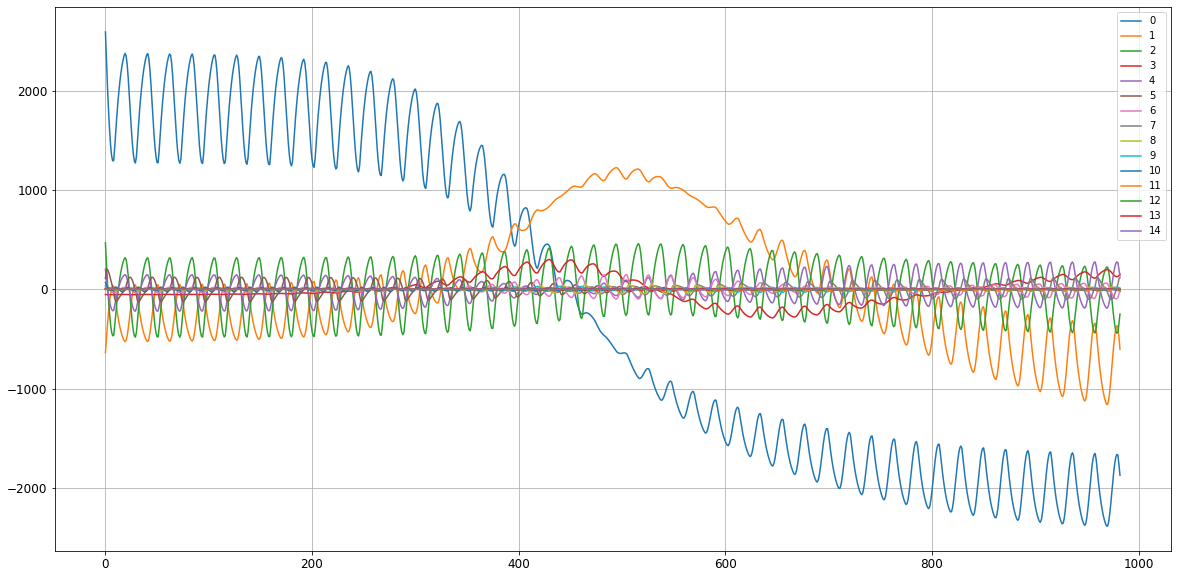

In [15]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(X_train_compressed[:len(times)*1]);
ax.grid()
ax.legend(range(15))

In [16]:
pca_size = X_train_compressed.shape[1]
X_train_compressed.shape

(39320, 15)

In [17]:
def concat_timesteps(X_train, ntimes, step, times):
    X_train_concat = []
    for j in range(len(X_train)//len(times)):
        for i in range(j*len(times), j*len(times)+(len(times)-ntimes*step)):
            X_train_concat.append(X_train[i:i+ntimes*step:step])
    return np.array(X_train_concat)

In [18]:
ntimes = 10 # Consecutive times for the GAN
step = 2 # step between times

X_train_concat = concat_timesteps(X_train_scaled, ntimes, step, times)
X_train_concat_flatten = X_train_concat.reshape(X_train_concat.shape[0], codings_size*ntimes )

In [19]:
print(X_train_concat.shape)
print(X_train_concat_flatten.shape)

(38520, 10, 17)
(38520, 170)


In [20]:
BATCH_SIZE = 128
latent_space = 100

# Create a tensorflow dataset and split it into batches
train_dataset = X_train_concat.reshape(X_train_concat.shape[0], ntimes, codings_size , 1).astype('float32')
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(X_train_concat))
train_dataset = train_dataset.batch(BATCH_SIZE)
num=0
for data in train_dataset:
    print(data.shape)
    num+=1
print("iteration num: ", num)

(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 1)
(128, 10, 17, 

# Training

In [21]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(5*5*256, use_bias=False, input_shape=(latent_space,)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.2))

    model.add(keras.layers.Reshape((5, 5, 256)))

    model.add(keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.2))

    model.add(keras.layers.Conv2DTranspose(64, (3, 3), strides=(1, 2), padding='same', output_padding=[0,0], use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU(0.2))

    model.add(keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', output_padding=[1,0], use_bias=False, activation='tanh'))

    return model

In [22]:
# generator = make_generator_model()
# generator.summary()

In [23]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[10, 17, 1]))
    model.add(keras.layers.LeakyReLU(0.2))

    model.add(keras.layers.Conv2D(128, (3, 3), strides=(1, 2), padding='same'))
#     model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LayerNormalization())
    model.add(keras.layers.LeakyReLU(0.2))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(1))

    return model

In [24]:
# discriminator = make_discriminator_model()
# discriminator.summary()

In [25]:
from tensorflow.keras.models import load_model
generator, discriminator = load_model('../input/wgan-40-xiugai-4800/wgan-40-xiugai-4800.h5').layers

In [26]:
gan = keras.models.Sequential([generator, discriminator])

In [27]:
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

def discriminator_loss(real_output,fake_output):
    return tf.reduce_mean(fake_output)-tf.reduce_mean(real_output)

In [28]:
generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

In [29]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0., beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0., beta_2=0.9)

In [30]:
# discriminator iterations per generator iteration
n_critic = 5

# plot
num_examples_to_generate = 5
seed = tf.random.normal([num_examples_to_generate, latent_space])

In [31]:
#current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
generator_log_dir = './logs/gradient_tape/generator'
discriminator_log_dir = './logs/gradient_tape/discriminator'

generator_summary_writer = tf.summary.create_file_writer(generator_log_dir)
discriminator_summary_writer = tf.summary.create_file_writer(discriminator_log_dir)

In [32]:
def gradient_penalty(f, real, fake):
    
    def _interpolate(a, b):
        shape = [tf.shape(a)[0]] + [1] * (a.shape.ndims - 1)
        alpha = tf.random.uniform(shape=shape, minval=0., maxval=1.)
        inter = a + alpha * (b - a)
        inter.set_shape(a.shape)
        return inter

    x = _interpolate(real, fake)
    with tf.GradientTape() as t:
        t.watch(x)
        pred = f(x)
    grad = t.gradient(pred, x)
    norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
    gp = tf.reduce_mean((norm - 1.)**2)

    return gp

In [33]:
@tf.function
def train_G(batch):
    with tf.GradientTape() as gen_tape:
        if batch.shape[0]==BATCH_SIZE:
            noise = tf.random.normal([BATCH_SIZE, latent_space])
        else:
            noise = tf.random.normal([120, latent_space])

        generated_images = generator(noise, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss

In [34]:
@tf.function
def train_D(batch):
    with tf.GradientTape() as disc_tape:
        if batch.shape[0]==BATCH_SIZE:
            noise = tf.random.normal([BATCH_SIZE, latent_space])
        else:
            noise = tf.random.normal([120, latent_space])

        generated_images = generator(noise, training=True)

        real_output = discriminator(batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        disc_loss_without = discriminator_loss(real_output, fake_output)
        gp = gradient_penalty(functools.partial(discriminator, training=True), batch, generated_images)
        disc_loss = discriminator_loss(real_output, fake_output) + gp*10.0
        
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return disc_loss_without

In [35]:
@tf.function
def train_step(batch):
    for _ in range(n_critic):
        disc_loss_without = train_D(batch)

    gen_loss = train_G(batch)


    generator_mean_loss(gen_loss)
    discriminator_mean_loss(disc_loss_without)

In [36]:
def train(dataset, epochs):
    hist = []
    for epoch in range(epochs):
        start = time.time()
        print("Epoch {}/{}".format(epoch + 1, epochs))   

        for batch in dataset:

            train_step(batch)
        
        with generator_summary_writer.as_default():
            tf.summary.scalar('generator_loss', generator_mean_loss.result(), step=epoch)

        with discriminator_summary_writer.as_default():
            tf.summary.scalar('discriminator_loss', discriminator_mean_loss.result(), step=epoch)
        
        hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])

        generator_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()
        
        print("discriminator: {:.6f}".format(hist[-1][1]), end=' - ')
        print("generator: {:.6f}".format(hist[-1][0]), end=' - ')    
        print ('{:.0f}s'.format( time.time()-start))

        # Global variables are used below
        if epoch%100 == 0: 
            # Plot generated data
            X_generated = scaler.inverse_transform(generator.predict(seed).reshape(num_examples_to_generate*ntimes,codings_size))
            R0_generated = X_generated[:,pca_size:]
            X_generated = pca_compressed.inverse_transform(X_generated[:,:pca_size])
            X_generated = X_generated.reshape(num_examples_to_generate, ntimes, len(groups)*nl*nc)
            fig, ax = plt.subplots(num_examples_to_generate*2,len(groups), figsize=[20,num_examples_to_generate*5])
            for j in range(num_examples_to_generate):
                for i, group in enumerate(groups):
                    for k in range(0,10,10): 
                        ax.flatten()[i+2*j*len(groups)].plot(X_generated[j][:,i*nl*nc+4+10*k], '-')
                for i, group in enumerate(groups):
                    im = ax.flatten()[i+(2*j+1)*len(groups)].imshow(X_generated[j].reshape(ntimes,len(groups),nl,nc)[4,i,:,:])
                    fig.colorbar(im, ax=ax.flatten()[i+(2*j+1)*len(groups)])
            plt.show() 
            
            print()
            print('R0 generated:')
            print(R0_generated)
            print()
                    
            # Save model
            gan.save('./'+'wgan-40-xiugai-'+str(3100+epoch)+'.h5')    
            
            # plot loss
            print('Loss: ')
            fig, ax = plt.subplots(1,1, figsize=[20,10])
            ax.plot(hist)
            ax.legend(['loss_gen', 'loss_disc'])
            ax.set_yscale('log')
            ax.grid()
            plt.show()
            
    return hist

In [37]:
# hist = train(train_dataset, epochs=1910)

# Prediction

In [38]:
#weight = np.ones(codings_size)
#weight = np.concatenate((pca_compress.explained_variance_, np.mean(pca_compress.explained_variance_).repeat(2)),axis=None)
weight = np.concatenate((pca_compressed.singular_values_, np.mean(pca_compressed.singular_values_).repeat(2)),axis=None)
#weight = np.concatenate((pca_compress.singular_values_, np.min(pca_compress.singular_values_).repeat(2)),axis=None)

weight = tf.constant(weight, dtype=tf.float32)
weight

<tf.Tensor: shape=(17,), dtype=float32, numpy=
array([3.3330681e+05, 1.2166467e+05, 5.2567664e+04, 2.9727166e+04,
       2.4324557e+04, 1.0762123e+04, 8.6157656e+03, 7.9793633e+03,
       2.8411521e+03, 2.2501648e+03, 2.0850576e+03, 1.5321442e+03,
       8.2077777e+02, 5.9175067e+02, 1.9133507e+02, 3.9950699e+04,
       3.9950699e+04], dtype=float32)>

In [39]:
mse = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(1e-2)

def mse_loss(inp, outp):
    inp = tf.reshape(inp, [-1, codings_size])*tf.math.sqrt(weight)
    outp = tf.reshape(outp, [-1, codings_size])*tf.math.sqrt(weight)
    return mse(inp, outp)

In [40]:
@tf.function
def opt_step(latent_values, real_coding):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False) 
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])   

    gradient = tape.gradient(loss, latent_values)  
    optimizer.apply_gradients(zip([gradient], [latent_values]))  
    
    return loss

In [41]:
def optimize_coding(real_coding):
    latent_values = tf.random.normal([len(real_coding), latent_size], mean=0.0, stddev=0.01)  
    latent_values = tf.Variable(latent_values)     #make input a tensorflow variable so it can be trained
    
    loss = []
    for epoch in range(1000):
        loss.append(opt_step(latent_values, real_coding).numpy())
        
    plt.plot(loss)
    #plt.grid()
    plt.show
        
    return latent_values, loss[-1]  

In [42]:
n = 400
real_coding = X_train_concat_flatten[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

Initial point losses:  - 19s
[41.724358, 3.012956, 2.9450188, 2.586564, 2.5840323, 2.5760822, 2.5784895, 2.5889883, 2.9669178, 2.9596407]
Loss:  2.576047
<tf.Variable 'Variable:0' shape=(1, 100) dtype=float32, numpy=
array([[ 3.82156596e-02, -2.95386259e-02,  4.48373258e-02,
        -9.34230350e-03,  4.29030746e-01,  4.74274248e-01,
        -5.55656441e-02, -6.26392737e-02,  2.16074735e-01,
         2.61584371e-01, -4.60961759e-02,  1.15144491e-01,
         3.51169854e-02, -6.43271282e-02, -6.31242394e-02,
        -3.65528204e-02,  9.27891955e-02, -2.60452256e-02,
         9.82416123e-02, -2.72130102e-01,  6.84885010e-02,
         2.19176829e-01, -7.13379234e-02,  2.51511812e-01,
        -3.19600664e-02,  2.38444880e-02,  7.68279955e-02,
         1.28818005e-01, -6.33221716e-02,  7.90433213e-02,
        -1.98429096e-02, -5.00098057e-02,  6.13019429e-02,
         3.10608178e-01,  1.82456389e-01,  9.47384983e-02,
        -1.09343238e-01,  9.64745358e-02,  1.57917842e-01,
        -1.88488

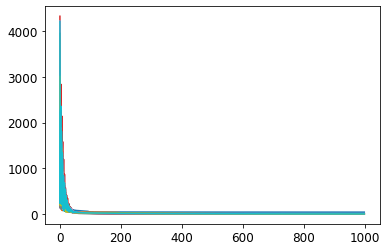

In [43]:
latent_size = 100
start = time.time()
list_latent_values = []
list_loss = []
for _ in range(10):   
    latent_values, loss = optimize_coding(real_coding)
    list_latent_values.append(latent_values)
    list_loss.append(loss)
latent_values = list_latent_values[np.argmin(list_loss)]
print('Initial point losses: ', end=' - ')
print ('{:.0f}s'.format( time.time()-start))
print(list_loss)

print('Loss: ', mse_loss(generator(latent_values)[:,:(ntimes - 1),:,:], real_coding).numpy())
print(latent_values)

In [44]:
X_generated = scaler.inverse_transform(generator.predict(tf.convert_to_tensor(latent_values)).reshape(ntimes,codings_size))
R0_generated = X_generated[:,pca_size:]
X_generated = pca_compressed.inverse_transform(X_generated[:,:pca_size])
X_generated = X_generated.reshape(ntimes, len(groups)*nl*nc)

In [45]:
X_real = scaler.inverse_transform(X_train_concat_flatten[n].reshape(ntimes,codings_size))
R0_real = X_real[:,pca_size:]
X_real = pca_compressed.inverse_transform(X_real[:,:pca_size])
X_real = X_real.reshape(ntimes, len(groups)*nl*nc)

In [46]:
print(R0_generated)
print()
print(R0_real[0])

[[ 9.108027  10.088723 ]
 [ 9.10093   10.132126 ]
 [ 9.095171  10.080367 ]
 [ 9.0982    10.123179 ]
 [ 9.122784  10.058251 ]
 [ 9.072473  10.1013775]
 [ 9.109387   9.979456 ]
 [ 8.9864    10.087233 ]
 [ 9.186326   9.928411 ]
 [ 9.176583  10.03652  ]]

[ 9.10159075 10.08695344]


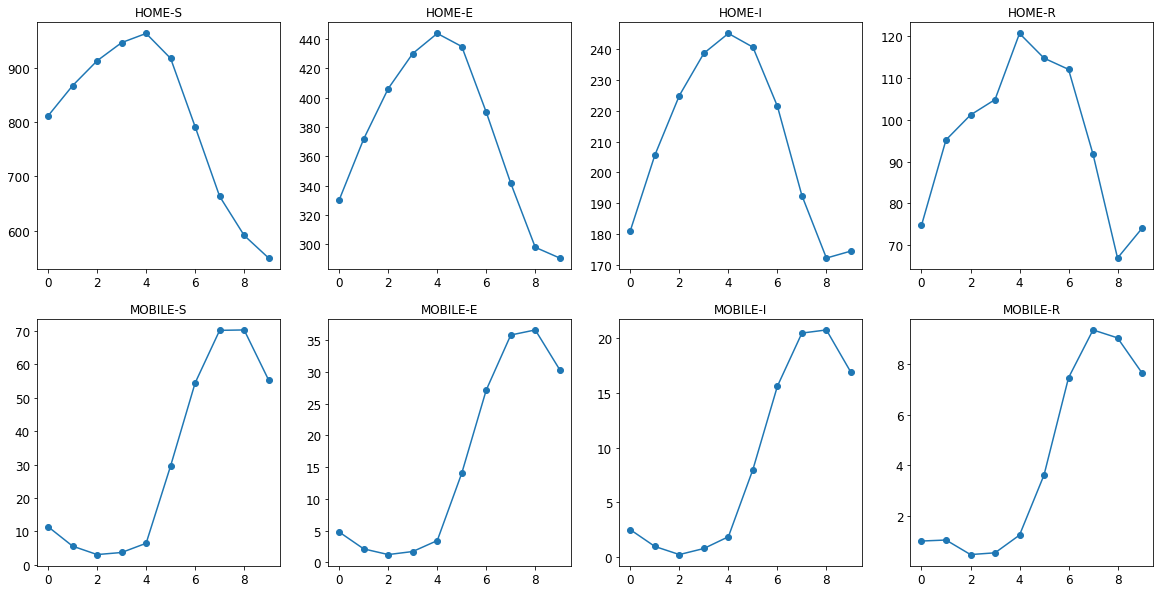

In [47]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:,i*nl*nc+4], '-o')
    ax.flatten()[i].set_title(group)
#plt.savefig('GAN_generateddata.png')

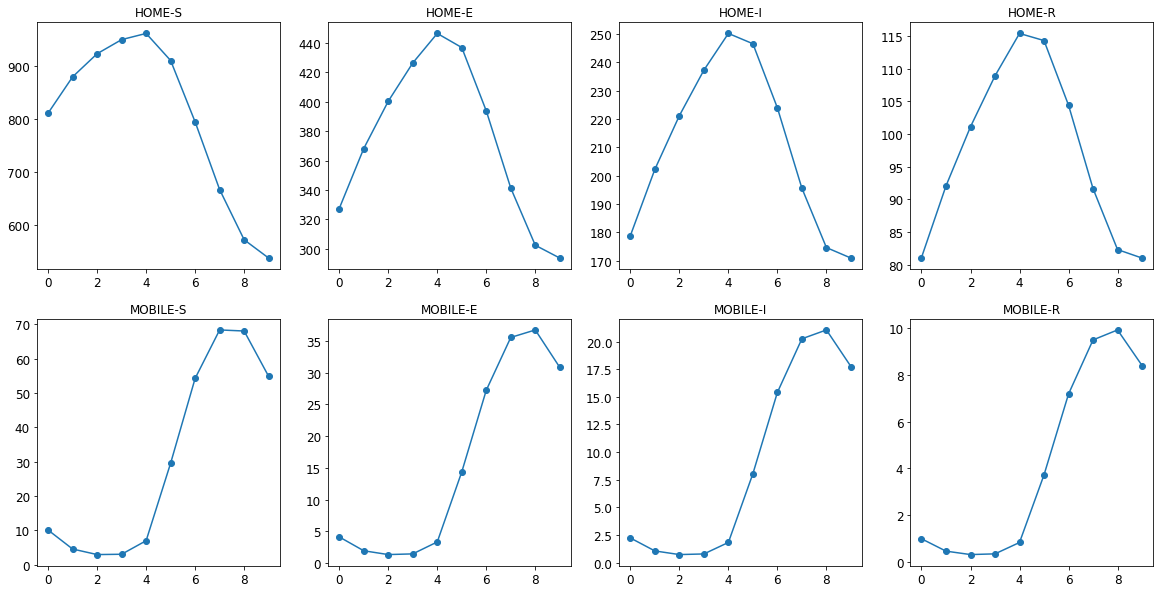

In [48]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_real[:,i*nl*nc+4], '-o')
    ax.flatten()[i].set_title(group)
#plt.savefig('GAN_generateddata.png')

# predict multiple points

run_1

In [49]:
def optimize_coding(latent_values, real_coding, epochs=1000):
    
    loss = []
    for epoch in range(epochs):
        loss.append(opt_step(latent_values, real_coding).numpy())
        
    plt.plot(loss)
    #plt.grid()
    plt.show
        
    return latent_values, loss[-1]  #returns the optimized input that generates the desired output

In [50]:
@tf.function
def opt_step(latent_values, real_coding):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False) 
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])   

    gradient = tape.gradient(loss, latent_values)  
    optimizer.apply_gradients(zip([gradient], [latent_values]))  
    
    return loss

Initial point losses: [2.9814618, 2.5141742, 2.9182062, 2.5710874, 2.914005, 2.689553, 2.9621866, 2.532438, 2.9173768, 2.511994]
Loss iteration 1: 2.6957726 - 2s
Loss iteration 2: 2.8163843 - 2s
Loss iteration 3: 4.091977 - 2s
Loss iteration 4: 2.916704 - 1s
Loss iteration 5: 3.0714734 - 2s
Loss iteration 6: 4.572573 - 2s
Loss iteration 7: 3.6490266 - 2s
Loss iteration 8: 5.2041526 - 2s
Loss iteration 9: 3.9774666 - 2s
Loss iteration 10: 3.7869093 - 2s
Loss iteration 11: 4.5688195 - 2s
Loss iteration 12: 5.658833 - 2s
Loss iteration 13: 4.4769874 - 2s
Loss iteration 14: 3.8635352 - 1s
Loss iteration 15: 3.5310972 - 2s
Loss iteration 16: 3.041225 - 2s
Loss iteration 17: 3.3435977 - 2s
Loss iteration 18: 4.5030017 - 1s
Loss iteration 19: 4.598515 - 1s
Loss iteration 20: 4.2524943 - 1s
Loss iteration 21: 4.960275 - 2s
Loss iteration 22: 4.244754 - 1s
Loss iteration 23: 6.3230476 - 2s
Loss iteration 24: 4.155955 - 2s
Loss iteration 25: 3.4259892 - 2s
Loss iteration 26: 5.341868 - 1s
Loss i

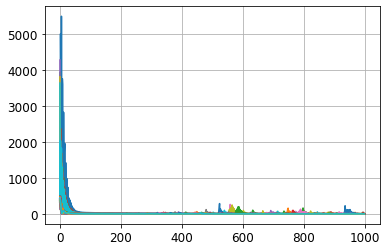

In [51]:
np.random.seed(0)
tf.random.set_seed(0)

run = 0
lag = 400
n = len(times)*run - ntimes*step*run + lag
nplot = n + run*ntimes*step 

real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)
R0s_run = real_coding[0,-2:]

list_latent_values = []
list_loss = []
for _ in range(10):
    latent_values = tf.random.normal([len(real_coding), latent_size], mean=0.0, stddev=0.01)  
    latent_values = tf.Variable(latent_values)     
    latent_values, loss = optimize_coding(latent_values, real_coding, epochs=1000)
    list_latent_values.append(latent_values)
    list_loss.append(loss)
latent_values = list_latent_values[np.argmin(list_loss)]
print('Initial point losses: ', end='')
print(list_loss)
        
X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size))
gen_predict = X_predict[-1]
gen_predict[-2:] = R0s_run

real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(100): #range(2000,len(X_train_concat)-1):
    start = time.time()
    latent_values, loss = optimize_coding(latent_values, real_coding, epochs=1000)
    print('Loss iteration '+str(i+1)+': '+str(loss), end=' - ')
        
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy().flatten()
    X_predict.append(gen_predict)
    gen_predict[-2:] = R0s_run
    
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    print ('{:.0f}s'.format( time.time()-start))
    
X_predict = np.array(X_predict)
plt.grid()

In [52]:
X_generated = scaler.inverse_transform(X_predict)
R0_generated = X_generated[:,pca_size:]
X_generated = pca_compressed.inverse_transform(X_generated[:,:pca_size])
X_generated = X_generated.reshape(len(X_predict), len(groups)*nl*nc)
X_generated[X_generated<0] = 0 

In [53]:
X_real = scaler.inverse_transform(X_train_concat_flatten[n].reshape(ntimes,codings_size))
R0_real = X_real[:,pca_size:]

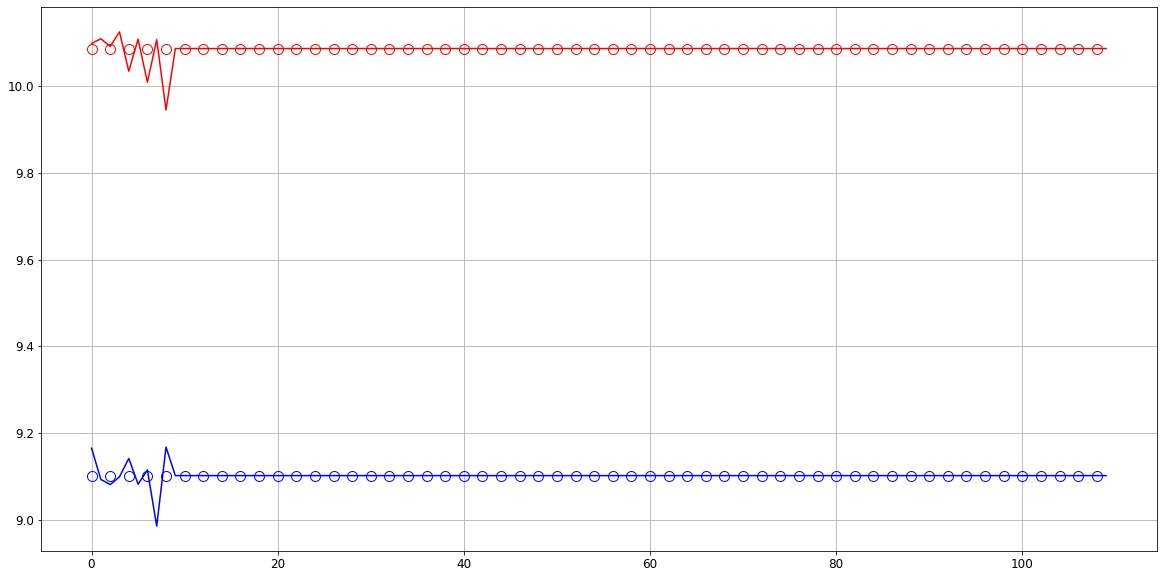

In [54]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(R0_generated[:,0], 'b-')
ax.plot(list(R0_real[0,:1])*len(R0_generated), 'bo', markevery=2, fillstyle='none', markersize = 10)
ax.plot(R0_generated[:,1], 'r-')
ax.plot(list(R0_real[0,1:])*len(R0_generated), 'ro', markevery=2, fillstyle='none', markersize = 10)
plt.grid()

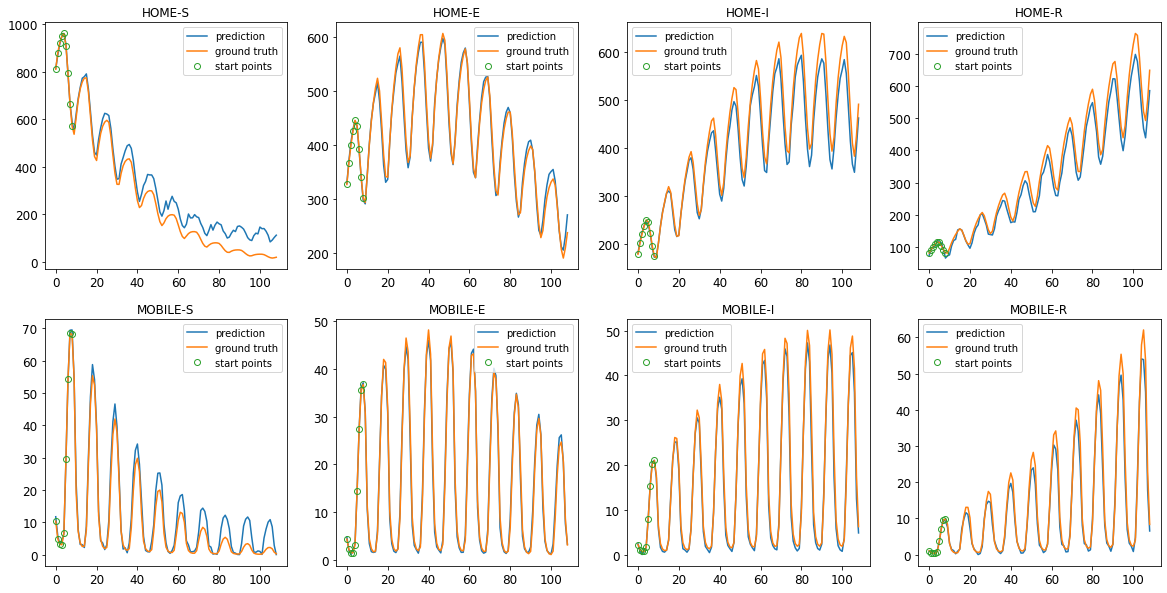

In [55]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:(ntimes-1)+100,i*nl*nc+4], '-')
    ax.flatten()[i].plot(X_train_1D[nplot:nplot+((ntimes-1)+100)*step:step,i*nl*nc+4], '-')
    ax.flatten()[i].plot(X_train_1D[nplot:nplot+((ntimes-1))*step:step,i*nl*nc+4], 'o', fillstyle='none', markersize = 6)
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground truth', 'start points'])
#plt.savefig('GAN_generateddata.png')

run_33

In [56]:
@tf.function
def opt_step(latent_values, real_coding):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False) 
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])   

    gradient = tape.gradient(loss, latent_values)  
    optimizer.apply_gradients(zip([gradient], [latent_values]))  
    
    return loss

Initial point losses: [6.1822734, 7.084059, 6.840446, 7.2945347, 7.4888415, 784.72186, 7.7560797, 7.163618, 6.8126316, 781.6466]
Loss iteration 1: 3.3521936 - 2s
Loss iteration 2: 3.7614768 - 1s
Loss iteration 3: 2.640341 - 1s
Loss iteration 4: 4.157282 - 2s
Loss iteration 5: 3.6598003 - 1s
Loss iteration 6: 6.211289 - 2s
Loss iteration 7: 4.398098 - 2s
Loss iteration 8: 4.660874 - 2s
Loss iteration 9: 5.618744 - 2s
Loss iteration 10: 4.5004425 - 2s
Loss iteration 11: 4.0786815 - 2s
Loss iteration 12: 5.412699 - 2s
Loss iteration 13: 4.2342362 - 2s
Loss iteration 14: 5.9030952 - 2s
Loss iteration 15: 4.037452 - 2s
Loss iteration 16: 2.7779737 - 1s
Loss iteration 17: 3.1422915 - 2s
Loss iteration 18: 4.481559 - 2s
Loss iteration 19: 4.4685917 - 2s
Loss iteration 20: 4.0397716 - 2s
Loss iteration 21: 10.291737 - 1s
Loss iteration 22: 7.9306235 - 2s
Loss iteration 23: 6.289984 - 1s
Loss iteration 24: 4.329493 - 2s
Loss iteration 25: 5.408327 - 2s
Loss iteration 26: 8.190322 - 1s
Loss iter

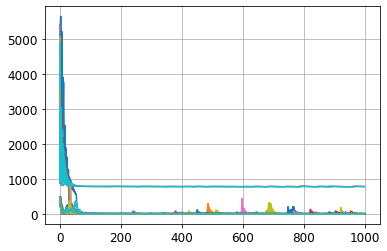

In [57]:
np.random.seed(0)
tf.random.set_seed(0)

run = 32
lag = 400
n = len(times)*run - ntimes*step*run + lag
nplot = n + run*ntimes*step 

real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)
R0s_run = real_coding[0,-2:]

list_latent_values = []
list_loss = []
for _ in range(10):
    latent_values = tf.random.normal([len(real_coding), latent_size], mean=0.0, stddev=0.01)  
    latent_values = tf.Variable(latent_values)     
    latent_values, loss = optimize_coding(latent_values, real_coding, epochs=1000)
    list_latent_values.append(latent_values)
    list_loss.append(loss)
latent_values = list_latent_values[np.argmin(list_loss)]
print('Initial point losses: ', end='')
print(list_loss)
        
X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size))
gen_predict = X_predict[-1]
gen_predict[-2:] = R0s_run

real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(100): #range(2000,len(X_train_concat)-1):
    start = time.time()
    latent_values, loss = optimize_coding(latent_values, real_coding, epochs=1000)
    print('Loss iteration '+str(i+1)+': '+str(loss), end=' - ')
        
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy().flatten()
    X_predict.append(gen_predict)
    gen_predict[-2:] = R0s_run
    
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    print ('{:.0f}s'.format( time.time()-start))
    
X_predict = np.array(X_predict)
plt.grid()

In [58]:
X_generated = scaler.inverse_transform(X_predict)
R0_generated = X_generated[:,pca_size:]
X_generated = pca_compressed.inverse_transform(X_generated[:,:pca_size])
X_generated = X_generated.reshape(len(X_predict), len(groups)*nl*nc)
X_generated[X_generated<0] = 0 

In [59]:
X_real = scaler.inverse_transform(X_train_concat_flatten[n].reshape(ntimes,codings_size))
R0_real = X_real[:,pca_size:]

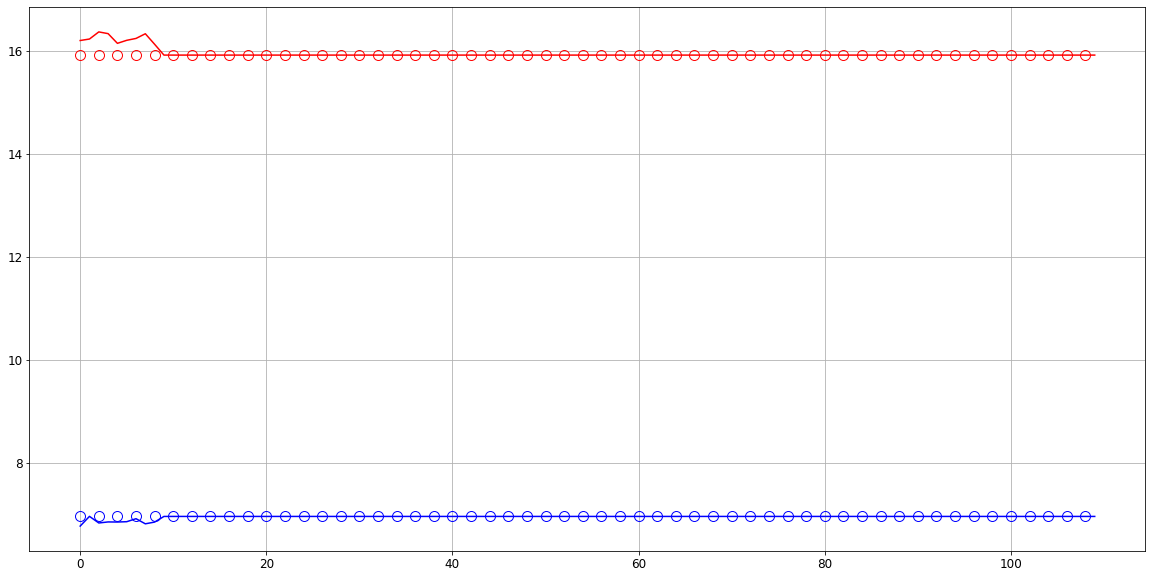

In [60]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(R0_generated[:,0], 'b-')
ax.plot(list(R0_real[0,:1])*len(R0_generated), 'bo', markevery=2, fillstyle='none', markersize = 10)
ax.plot(R0_generated[:,1], 'r-')
ax.plot(list(R0_real[0,1:])*len(R0_generated), 'ro', markevery=2, fillstyle='none', markersize = 10)
plt.grid()

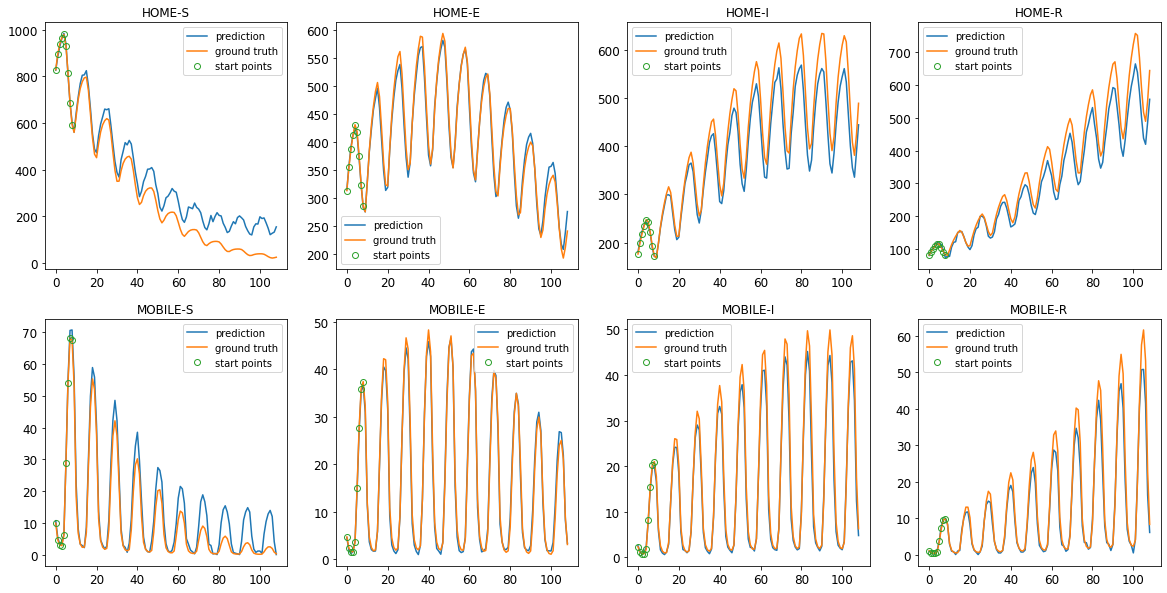

In [61]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:(ntimes-1)+100,i*nl*nc+4], '-')
    ax.flatten()[i].plot(X_train_1D[nplot:nplot+((ntimes-1)+100)*step:step,i*nl*nc+4], '-')
    ax.flatten()[i].plot(X_train_1D[nplot:nplot+((ntimes-1))*step:step,i*nl*nc+4], 'o', fillstyle='none', markersize = 6)
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground truth', 'start points'])
#plt.savefig('GAN_generateddata.png')

run_17

In [62]:
@tf.function
def opt_step(latent_values, real_coding):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False) 
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])   

    gradient = tape.gradient(loss, latent_values)  
    optimizer.apply_gradients(zip([gradient], [latent_values]))  
    
    return loss

Initial point losses: [659.7879, 667.1979, 667.43915, 695.55774, 668.7736, 668.2067, 1567.7131, 668.22095, 5.6414924, 668.2853]
Loss iteration 1: 6.18564 - 2s
Loss iteration 2: 4.509674 - 2s
Loss iteration 3: 3.7528415 - 2s
Loss iteration 4: 4.979447 - 1s
Loss iteration 5: 5.095 - 1s
Loss iteration 6: 5.1597595 - 2s
Loss iteration 7: 6.6076975 - 2s
Loss iteration 8: 5.555536 - 2s
Loss iteration 9: 7.0814915 - 1s
Loss iteration 10: 8.936473 - 1s
Loss iteration 11: 6.8530593 - 2s
Loss iteration 12: 7.5469413 - 1s
Loss iteration 13: 5.429041 - 1s
Loss iteration 14: 5.657118 - 2s
Loss iteration 15: 7.5138025 - 2s
Loss iteration 16: 6.7466464 - 2s
Loss iteration 17: 5.4116325 - 2s
Loss iteration 18: 8.986767 - 2s
Loss iteration 19: 7.786316 - 2s
Loss iteration 20: 7.8065395 - 2s
Loss iteration 21: 7.589059 - 2s
Loss iteration 22: 8.832491 - 1s
Loss iteration 23: 8.795528 - 1s
Loss iteration 24: 6.396038 - 1s
Loss iteration 25: 8.776887 - 2s
Loss iteration 26: 5.650348 - 1s
Loss iteration 27

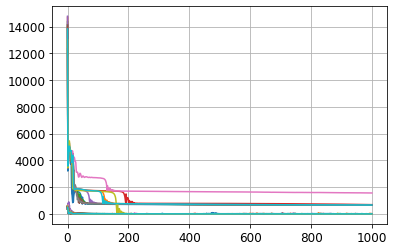

In [63]:
np.random.seed(0)
tf.random.set_seed(0)

run = 16
lag = 200
n = len(times)*run - ntimes*step*run + lag
nplot = n + run*ntimes*step 

real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)
R0s_run = real_coding[0,-2:]

list_latent_values = []
list_loss = []
for _ in range(10):
    latent_values = tf.random.normal([len(real_coding), latent_size], mean=0.0, stddev=0.01)  
    latent_values = tf.Variable(latent_values)     
    latent_values, loss = optimize_coding(latent_values, real_coding, epochs=1000)
    list_latent_values.append(latent_values)
    list_loss.append(loss)
latent_values = list_latent_values[np.argmin(list_loss)]
print('Initial point losses: ', end='')
print(list_loss)
        
X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size))
gen_predict = X_predict[-1]
gen_predict[-2:] = R0s_run

real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(100): #range(2000,len(X_train_concat)-1):
    start = time.time()
    latent_values, loss = optimize_coding(latent_values, real_coding, epochs=1000)
    print('Loss iteration '+str(i+1)+': '+str(loss), end=' - ')
        
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy().flatten()
    X_predict.append(gen_predict)
    gen_predict[-2:] = R0s_run
    
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    print ('{:.0f}s'.format( time.time()-start))
    
X_predict = np.array(X_predict)
plt.grid()

In [64]:
X_generated = scaler.inverse_transform(X_predict)
R0_generated = X_generated[:,pca_size:]
X_generated = pca_compressed.inverse_transform(X_generated[:,:pca_size])
X_generated = X_generated.reshape(len(X_predict), len(groups)*nl*nc)
X_generated[X_generated<0] = 0 

In [65]:
X_real = scaler.inverse_transform(X_train_concat_flatten[n].reshape(ntimes,codings_size))
R0_real = X_real[:,pca_size:]

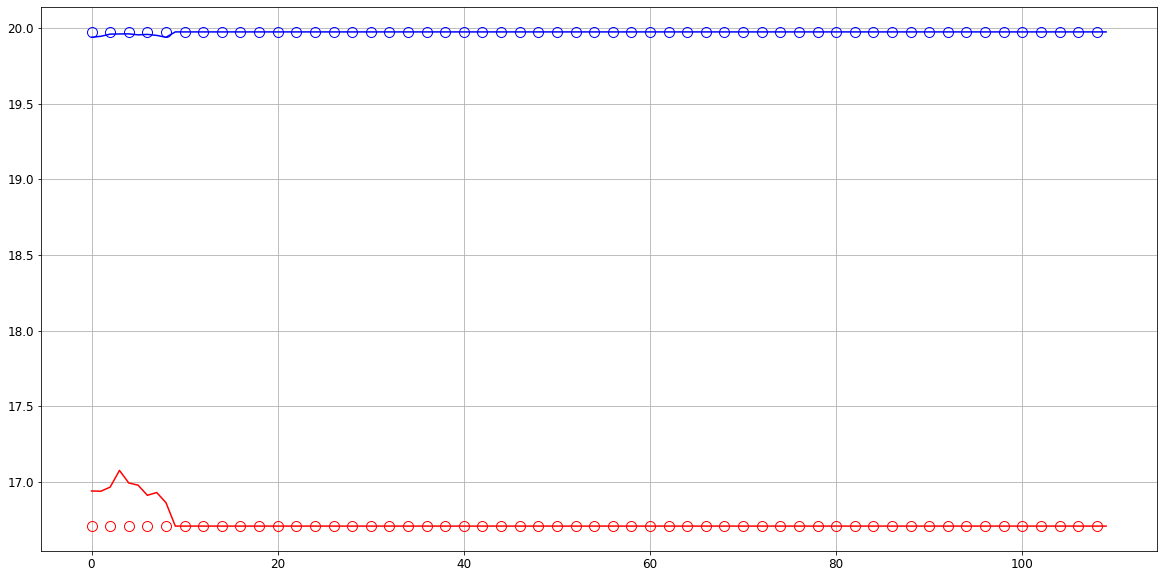

In [66]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(R0_generated[:,0], 'b-')
ax.plot(list(R0_real[0,:1])*len(R0_generated), 'bo', markevery=2, fillstyle='none', markersize = 10)
ax.plot(R0_generated[:,1], 'r-')
ax.plot(list(R0_real[0,1:])*len(R0_generated), 'ro', markevery=2, fillstyle='none', markersize = 10)
plt.grid()

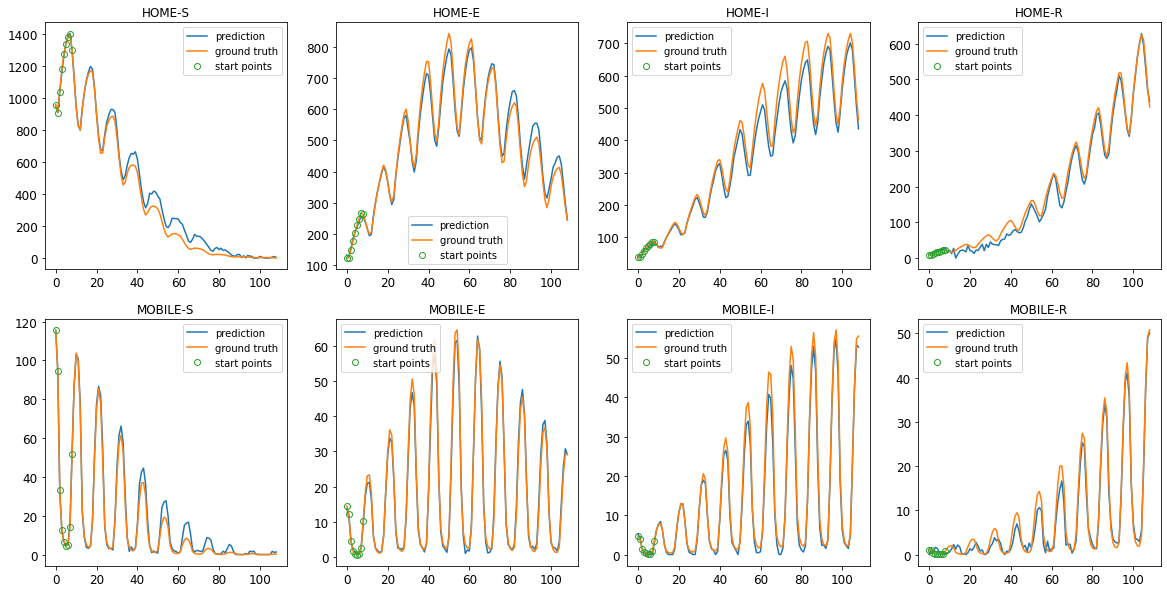

In [67]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:(ntimes-1)+100,i*nl*nc+4], '-')
    ax.flatten()[i].plot(X_train_1D[nplot:nplot+((ntimes-1)+100)*step:step,i*nl*nc+4], '-')
    ax.flatten()[i].plot(X_train_1D[nplot:nplot+((ntimes-1))*step:step,i*nl*nc+4], 'o', fillstyle='none', markersize = 6)
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground truth', 'start points'])
#plt.savefig('GAN_generateddata.png')

run_17 another point 84

In [68]:
@tf.function
def opt_step(latent_values, real_coding):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False) 
        loss = mse_loss(real_coding, gen_output[:,:(ntimes - 1),:,:])   

    gradient = tape.gradient(loss, latent_values)  
    optimizer.apply_gradients(zip([gradient], [latent_values]))  
    
    return loss

Initial point losses: [659.78796, 667.1976, 667.16406, 687.9456, 669.01355, 669.1467, 674.96704, 2710.393, 6.412034, 1584.6289]
Loss iteration 1: 6.0224323 - 2s
Loss iteration 2: 5.505096 - 1s
Loss iteration 3: 3.5860546 - 2s
Loss iteration 4: 3.5577872 - 1s
Loss iteration 5: 5.313155 - 1s
Loss iteration 6: 4.805276 - 1s
Loss iteration 7: 6.807279 - 1s
Loss iteration 8: 6.090596 - 1s
Loss iteration 9: 6.5501246 - 2s
Loss iteration 10: 5.649759 - 2s
Loss iteration 11: 7.7547126 - 1s
Loss iteration 12: 7.63164 - 1s
Loss iteration 13: 5.4607377 - 1s
Loss iteration 14: 8.452053 - 1s
Loss iteration 15: 6.334959 - 2s
Loss iteration 16: 6.957979 - 2s
Loss iteration 17: 5.7384963 - 2s
Loss iteration 18: 9.527174 - 2s
Loss iteration 19: 7.1734457 - 2s
Loss iteration 20: 7.5982175 - 2s
Loss iteration 21: 8.044282 - 2s
Loss iteration 22: 7.20454 - 2s
Loss iteration 23: 7.01078 - 2s
Loss iteration 24: 5.649141 - 2s
Loss iteration 25: 7.230361 - 2s
Loss iteration 26: 5.2578015 - 2s
Loss iteration 2

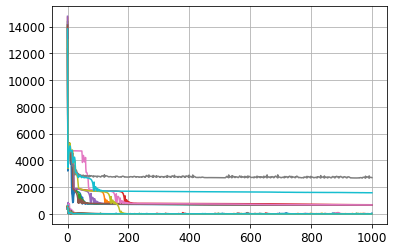

In [69]:
np.random.seed(0)
tf.random.set_seed(0)

run = 16
lag = 200
n = len(times)*run - ntimes*step*run + lag
nplot = n + run*ntimes*step 

real_coding = X_train_concat[n].reshape(1,-1)
real_coding = real_coding[:,:codings_size*(ntimes - 1)]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)
R0s_run = real_coding[0,-2:]

list_latent_values = []
list_loss = []
for _ in range(10):
    latent_values = tf.random.normal([len(real_coding), latent_size], mean=0.0, stddev=0.01)  
    latent_values = tf.Variable(latent_values)     
    latent_values, loss = optimize_coding(latent_values, real_coding, epochs=1000)
    list_latent_values.append(latent_values)
    list_loss.append(loss)
latent_values = list_latent_values[np.argmin(list_loss)]
print('Initial point losses: ', end='')
print(list_loss)
        
X_predict = list(generator(latent_values).numpy().reshape(-1,codings_size))
gen_predict = X_predict[-1]
gen_predict[-2:] = R0s_run

real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
real_coding = tf.constant(real_coding)
real_coding = tf.cast(real_coding, dtype=tf.float32)

for i in range(100): #range(2000,len(X_train_concat)-1):
    start = time.time()
    latent_values, loss = optimize_coding(latent_values, real_coding, epochs=1000)
    print('Loss iteration '+str(i+1)+': '+str(loss), end=' - ')
        
    gen_predict = generator(latent_values)[:,(ntimes - 1):,:,:].numpy().flatten()
    X_predict.append(gen_predict)
    gen_predict[-2:] = R0s_run
    
    real_coding = np.concatenate((real_coding, gen_predict.reshape(1,-1)), axis=1)[:,codings_size:]
    real_coding = tf.constant(real_coding)
    real_coding = tf.cast(real_coding, dtype=tf.float32)
    print ('{:.0f}s'.format( time.time()-start))
    
X_predict = np.array(X_predict)
plt.grid()

In [70]:
X_generated = scaler.inverse_transform(X_predict)
R0_generated = X_generated[:,pca_size:]
X_generated = pca_compressed.inverse_transform(X_generated[:,:pca_size])
X_generated = X_generated.reshape(len(X_predict), len(groups)*nl*nc)
X_generated[X_generated<0] = 0 

In [71]:
X_real = scaler.inverse_transform(X_train_concat_flatten[n].reshape(ntimes,codings_size))
R0_real = X_real[:,pca_size:]

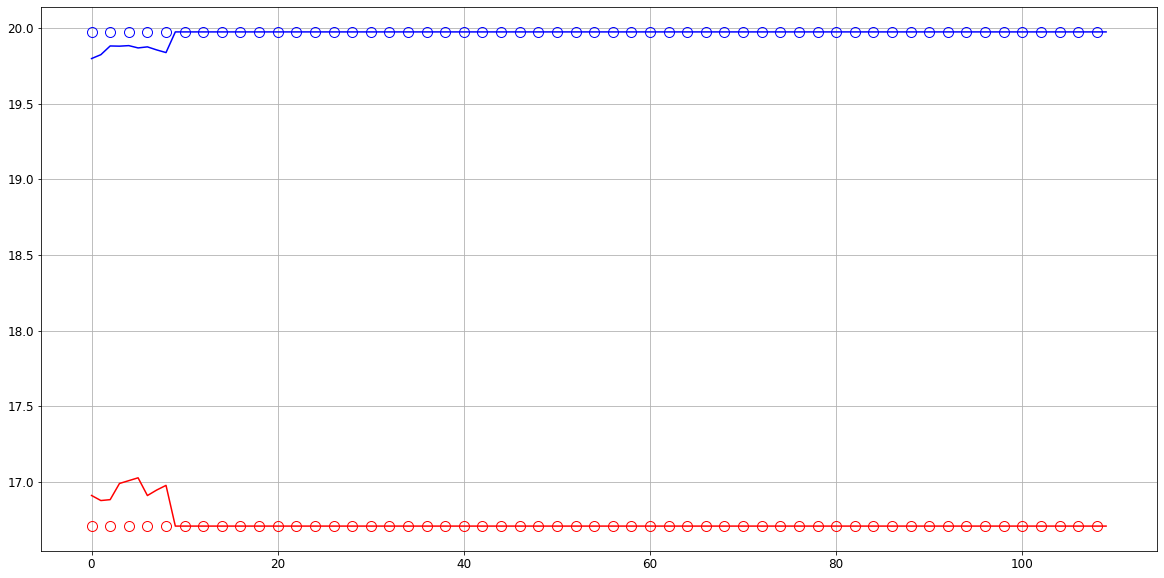

In [72]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(R0_generated[:,0], 'b-')
ax.plot(list(R0_real[0,:1])*len(R0_generated), 'bo', markevery=2, fillstyle='none', markersize = 10)
ax.plot(R0_generated[:,1], 'r-')
ax.plot(list(R0_real[0,1:])*len(R0_generated), 'ro', markevery=2, fillstyle='none', markersize = 10)
plt.grid()

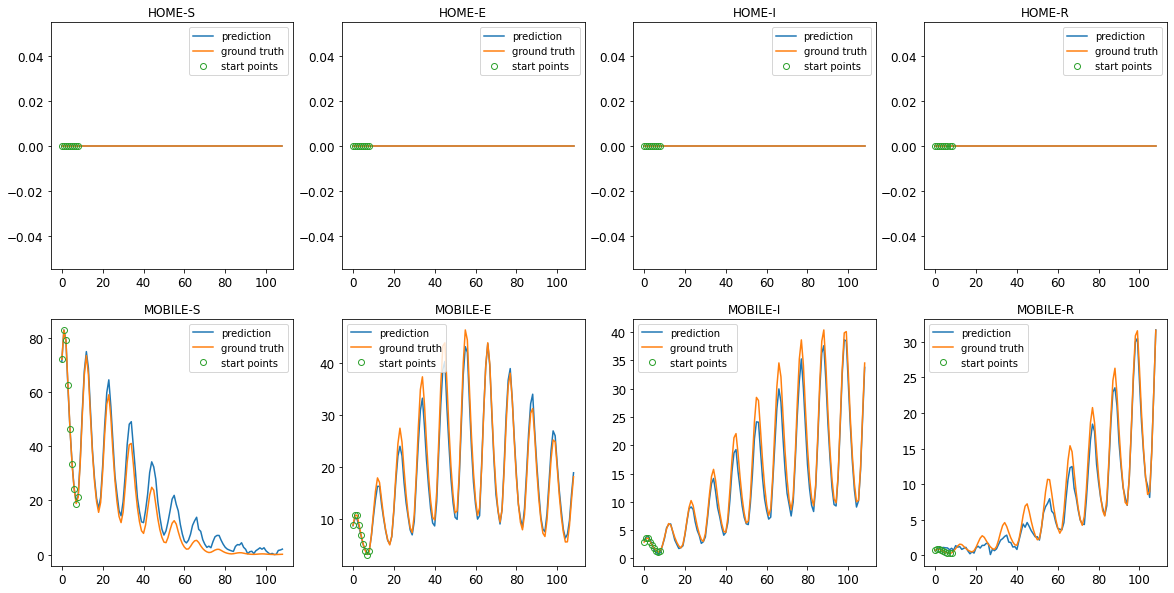

In [73]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(X_generated[:(ntimes-1)+100,i*nl*nc+84], '-')
    ax.flatten()[i].plot(X_train_1D[nplot:nplot+((ntimes-1)+100)*step:step,i*nl*nc+84], '-')
    ax.flatten()[i].plot(X_train_1D[nplot:nplot+((ntimes-1))*step:step,i*nl*nc+84], 'o', fillstyle='none', markersize = 6)
    ax.flatten()[i].set_title(group)
    ax.flatten()[i].legend(['prediction', 'ground truth', 'start points'])
#plt.savefig('GAN_generateddata.png')